In [ ]:
# Some portion of the code from 
# N. Audebert, B. Le Saux, and S. Lefèvre, “Beyond RGB: Very high resolution urban remote sensing with multimodal deep networks,” ISPRS J. Photogramm. Remote Sens., vol. 140, pp. 20–32, 2018, doi: 10.1016/j.isprsjprs.2017.11.011.

In [1]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as cb
# Torch imports
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
# from torch.utils.tensorboard import SummaryWriter
from modelsummary import summary
from Zdence import *
from IPython.display import clear_output 
from torch.utils.tensorboard import SummaryWriter

In [3]:
net = ZNet_v2()
net.cuda()
clear_output() 

In [4]:
model_name = "ZNet_dence6"
# model_name = "ESPNet"
# Parameters
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = "/home/mahmud/.ssh/main_project/data/Uavid/" # Replace with your "/path/to/the/Uavid/dataset/folder/"
BATCH_SIZE =25 # Number of samples in a mini-batch

LABELS = ["Clutter", "Building", "Road.", "Tree", "Low veg.", "Moving car","Static car","Human"] # Label names
# LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"]
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'uavid'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Postdam/'
    DATA_FOLDER = MAIN_FOLDER + '2_Ortho_RGB/top_potsdam_{}_RGB.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'
elif DATASET == 'uavid':
    MAIN_FOLDER = FOLDER + 'uavid/'
    DATA_FOLDER = MAIN_FOLDER + 'image/{}.png'
    LABEL_FOLDER = MAIN_FOLDER + 'label/{}.png'
    ERODED_FOLDER = MAIN_FOLDER + 'label/{}.png'

In [5]:


# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (0,0,0), # Impervious surfaces (white)
           1 : (128,0, 0),     # Buildings (blue)
           2 : (128, 64, 128),   # Low vegetation (cyan)
           3 : (0, 128, 0),     # Trees (green)
           4 : (128, 128, 0),   # Cars (yellow)
           5 : (64, 0, 128),
           6 : (192, 0, 192),
           7 : (64, 64, 0)}     # Clutter (red)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# # We load one tile from the dataset and we display it
# img = io.imread('/home/mahmud/.ssh/main_project/data/vaihingenpostdam/uavid/image/000000.png')
# fig = plt.figure()
# fig.add_subplot(121)
# plt.imshow(img)

# # We load the ground truth
# gt = io.imread('/home/mahmud/.ssh/main_project/data/vaihingenpostdam/uavid/label/000000.png')
# fig.add_subplot(122)
# plt.imshow(gt)
# plt.show()

# # We also check that we can convert the ground truth into an array format
# array_gt = convert_from_color(gt)
# print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)


For vaihingen dataset

In [7]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    #cb.set_theme()
    # cb.heatmap(cm,cmap='OrRd')
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [8]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [9]:

# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split(' ')[5:7]) for f in all_files]
elif DATASET == 'uavid':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split(' ')) for f in all_files]

# Exemple of a train/test split on Vaihingen :
train_ids = ['000000','000100','000200','000300','000400','000500','000600','000700',
'100000','100100','100200','100300','100400','100500','100600','100700',
'200000','200100','200200','200300','200400','200500','200600','200700',
'300000','300100','300200','300300','300400','300500','300600','300700',
'400000','400100','400200','400300','400400','400500','400600','400700',
'500000','500100','500200','500300','500400','500500','500600','500700',
'600000','600100','600200','600300','600400','600500','600600','600700',
'700000','700100','700200','700300','700400','700500','700600','700700',
'800000','800100','800200','800300','800400','800500','800600','800700',
'900000','900100','900200','900300','900400','900500','900600','900700',
'010000','010100','010200','010300','010400','010500','010600','010700']
#test_ids = [ '21', '15', '30'] 
test_ids = ['000800','000900',
'100800','100900',
'200800','200900',
'300800','300900',
'400800','400900',
'500800','500900',
'600800','600900',
'700800','700900',
'800800','800900',
'900800','900900',
'010800','010900'] 
# train_ids = ['2_10','2_11','2_12','3_10','3_11','4_10','7_9','2_10','4_12','5_10','5_12','6_7','6_8','6_9','6_10','6_11','6_12','7_7','7_8','7_9','7_10','7_11','7_12','7_10']
# test_ids = ['3_12','4_11','5_11'] 

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
# train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)
# print(len(all_ids+ all_files))


Tiles for training :  ['000000', '000100', '000200', '000300', '000400', '000500', '000600', '000700', '100000', '100100', '100200', '100300', '100400', '100500', '100600', '100700', '200000', '200100', '200200', '200300', '200400', '200500', '200600', '200700', '300000', '300100', '300200', '300300', '300400', '300500', '300600', '300700', '400000', '400100', '400200', '400300', '400400', '400500', '400600', '400700', '500000', '500100', '500200', '500300', '500400', '500500', '500600', '500700', '600000', '600100', '600200', '600300', '600400', '600500', '600600', '600700']
Tiles for testing :  ['000800', '000900', '100800', '100900', '200800', '200900']


For Vaihingen

In [11]:
import time
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        tic = time.perf_counter()

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)
           
        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [13]:
# from operator import truediv
def train(epochs, weights=WEIGHTS, save_epoch = 10):

    # BATCH_SIZE = 32
    #  moms = [0.4, 0.6, 0.9]
    #  decays = [0.0001,0.0005, 0.001]
    # #  for base_lr in learning_rates:
    #  for mom in moms:
    #     for weight_decay in decays:
    base_lr = 0.01
    iter_ = 0
 
    net.train()
    train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)
    optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum= 0.9, weight_decay= 0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [70, 90], gamma=0.0005)
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()
    tb = SummaryWriter(f'runs/results/{DATASET}_{model_name}')
    # tb = SummaryWriter(f'runs/prec_rec/uavid_{model_name}')
    criterion = nn.NLLLoss2d(weight=weights)    
    
    for e in range(1, epochs + 1):
        scheduler.step()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.data.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
    
            pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
            gt = target.data.cpu().numpy()[0]
            # true_pos,true_neg,false_pos,false_neg = evaluation_metrics(gt,pred)
            
            # prec = true_pos / (true_pos + false_pos + 0.0001 )
            # rec = true_pos / (true_pos + false_neg + 0.0001)
            Accuracy =  accuracy(pred, gt)
            #scheduler.step(Accuracy)
            if iter_ % 50 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]

                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            tb.add_scalar('Loss',loss.item(),iter_,e )
            # tb.add_scalar('Accuracy', Accuracy,iter_ )
            # tb.add_scalar('prec_recall',prec,rec,iter_)
            # tb.add_pr_curve('Precision_recall',gt,pred,iter_)
            del(data, target, loss)
    tb.close()

    if e % save_epoch == 0:
        # We validate with the largest possible stride for faster computing
        acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
    torch.save(net.state_dict(), './{}.pth'.format(model_name))

In [14]:
# net.load_state_dict(torch.load('/home/mahmud/.ssh/main_project/project_folder01/project/baseline-pytorch/Uavid_experiment/deeplab.pth'))

In [15]:
train(100)

Confusion matrix :
[[1301247  111101   30119   37219   20531       0       0       0]
 [ 107792 2906533     411   32248     591       0       0       0]
 [  31055   14309 1062606   26600    2346       0       0       0]
 [  30293   64088   20245 1454451   35995       0       0       0]
 [  38489   22064    5035   83135  215780       0       0       0]
 [ 142477   15046  117511    7008      25       0       0       0]
 [ 180661   67422   18910   18467    1309       0       0       0]
 [  24149    7395   36085    2771     881       0       0       0]]
---
8294400 pixels processed
Total accuracy : 83.67834924768518%
---
F1Score :
Clutter: 0.7753871730852883
Building: 0.9292678977155104
Road.: 0.8753516503160425
Tree: 0.8903972517662385
Low veg.: 0.6722526757856007
Moving car: 0.0
Static car: 0.0
Human: 0.0
---
Kappa: 0.7840597849090706
Confusion matrix :
[[ 6784045   595743   279380   401408   285260        0        0        0]
 [  490638 20254064    28111   296354    20069        0      

In [16]:
# net.load_state_dict(torch.load('/home/mahmud/.ssh/main_project/project_folder01/project/baseline-pytorch/Uavid_experiment/{}.pth'.format(model_name)))

In [20]:
# _, all_preds, all_gts,cm = test(net, test_ids, all=True, stride=32)

In [1]:
model_names = ["Uavid_ZNet_v2_global","Uavid_ZNet_v2mod","ESPNet","FPENet","deeplab","ZNet_dence_no_1x1_basicBlk_gr2_plus00"]
model_names2 = ["VaihingenZNet_v2_global","VaihingenZNet_v2mod","VaihingenESPNet","VaihingenFPENet","Vaihingendeeplab","VaihingenZNet_dence_new2"]

In [51]:
df = pd.DataFrame(cm)

In [52]:
df.to_csv('{}.csv'.format(model_name),index=False)

In [4]:
read = pd.read_csv('{}.csv'.format(model_names[5]))
read



,0,1,2,3,4,5,6,7
0,14586714,1877506,969486,1498294,1070954,1641,128231,0
1,1482707,36775652,21620,612373,231546,0,10602,17
2,1072183,123719,9403453,361680,46853,81618,44178,0
3,1228304,1019692,189800,27247479,2458959,6192,8776,765
4,866014,204403,63910,2398751,10714465,219,3116,54
5,22601,5200,257958,25307,1903,756986,50025,0
6,166395,250496,46183,66911,6234,24121,747314,367
7,76273,4382,63236,7730,10477,930,7354,29051


Uavid_ZNet_v2_global


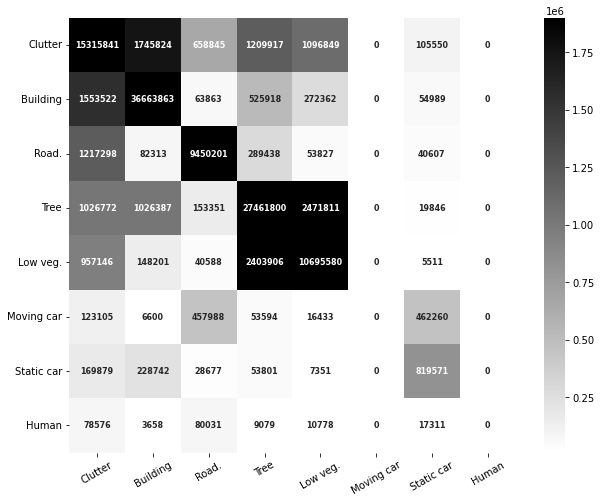

In [119]:
read = pd.read_csv('{}.csv'.format(model_names[0]))
lr_fig= plt.figure(figsize= [10,8])
matrix = cb.heatmap(read,cmap='gray_r', annot=True, fmt="d",vmin=10000,vmax=1900000,  annot_kws={
    'fontsize':8,
     'fontweight': 'bold',
     'fontfamily':'Arial'})
matrix.set_yticklabels(LABELS,rotation='horizontal')
matrix.set_xticklabels(LABELS,rotation=30)
fig = matrix.get_figure()
fig.savefig('{}.png'.format(model_names[0]),dpi=800)
print(model_names[0])